In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage.interpolation import shift

C:\Users\PTT_EP\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
def create_dataset(dataset,look_back=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back),:])
        dataY.append(dataset[(i+look_back),:])
    return np.array(dataX), np.array(dataY)

In [3]:
np.random.seed(7)
train_samples = 8000
test_samples = 100
data = pd.read_csv('ggexhaust_LSTM.csv', usecols=[0])
feature_name = data.columns.tolist()[0]
data = data.dropna()
fulldataset = data.values
print("Full sample: %d" %len(fulldataset))
dataset = fulldataset[len(fulldataset)-train_samples-test_samples:-test_samples]
dataset_test = fulldataset[len(fulldataset)-test_samples:]
print("Samples: %d" %len(dataset))
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset)*0.7)
test_size = (len(dataset)) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(feature_name)

Full sample: 8209
Samples: 8000
GG_EXHAUST_TEMP_T54_AVG


In [4]:
look_back = train_samples//10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

In [5]:
model = Sequential()
model.add(LSTM(4, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(trainX,trainY,epochs=100,batch_size=1,verbose=2)

Epoch 1/100
 - 6s - loss: 0.0097
Epoch 2/100
 - 7s - loss: 0.0047
Epoch 3/100
 - 7s - loss: 0.0031
Epoch 4/100
 - 7s - loss: 0.0028
Epoch 5/100
 - 7s - loss: 0.0028
Epoch 6/100
 - 7s - loss: 0.0027
Epoch 7/100
 - 7s - loss: 0.0025
Epoch 8/100
 - 7s - loss: 0.0024
Epoch 9/100
 - 7s - loss: 0.0024
Epoch 10/100
 - 7s - loss: 0.0021
Epoch 11/100
 - 7s - loss: 0.0020
Epoch 12/100
 - 7s - loss: 0.0018
Epoch 13/100
 - 7s - loss: 0.0020
Epoch 14/100
 - 7s - loss: 0.0019
Epoch 15/100
 - 7s - loss: 0.0019
Epoch 16/100
 - 7s - loss: 0.0020
Epoch 17/100
 - 8s - loss: 0.0018
Epoch 18/100
 - 8s - loss: 0.0018
Epoch 19/100
 - 8s - loss: 0.0019
Epoch 20/100
 - 8s - loss: 0.0018
Epoch 21/100
 - 9s - loss: 0.0018
Epoch 22/100
 - 9s - loss: 0.0019
Epoch 23/100
 - 9s - loss: 0.0016
Epoch 24/100
 - 9s - loss: 0.0017
Epoch 25/100
 - 9s - loss: 0.0016
Epoch 26/100
 - 10s - loss: 0.0015
Epoch 27/100
 - 10s - loss: 0.0015
Epoch 28/100
 - 10s - loss: 0.0017
Epoch 29/100
 - 9s - loss: 0.0015
Epoch 30/100
 - 9s -

In [6]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [7]:
future_dataset = []
futurePredict = []
future_dataset.append(dataset[-look_back:,:])
future_dataset = np.array(future_dataset)
future_dataset = np.reshape(future_dataset,(future_dataset.shape[0],1,future_dataset.shape[1]))
for i in range(100):
    p = model.predict(future_dataset)
    future_dataset[0,0] = shift(future_dataset[0,0],-1,cval=p[0,0])
    futurePredict.append(p[0,0])
futurePredict = scaler.inverse_transform([futurePredict])

In [8]:
unnorm_trainPredict = scaler.inverse_transform(trainPredict)
unnorm_trainY = scaler.inverse_transform(trainY)
unnorm_testPredict = scaler.inverse_transform(testPredict)
unnorm_testY = scaler.inverse_transform(testY)

In [9]:
trainScore = math.sqrt(mean_squared_error(unnorm_trainY[:,0],unnorm_trainPredict[:,0]))
print("Train score: %.2f RMSE" % trainScore)
testScore = math.sqrt(mean_squared_error(unnorm_testY[:,0],unnorm_testPredict[:,0]))
print("Test score: %.2f RMSE" % testScore)

Train score: 1.61 RMSE
Test score: 4.01 RMSE


MSE: 613.9826


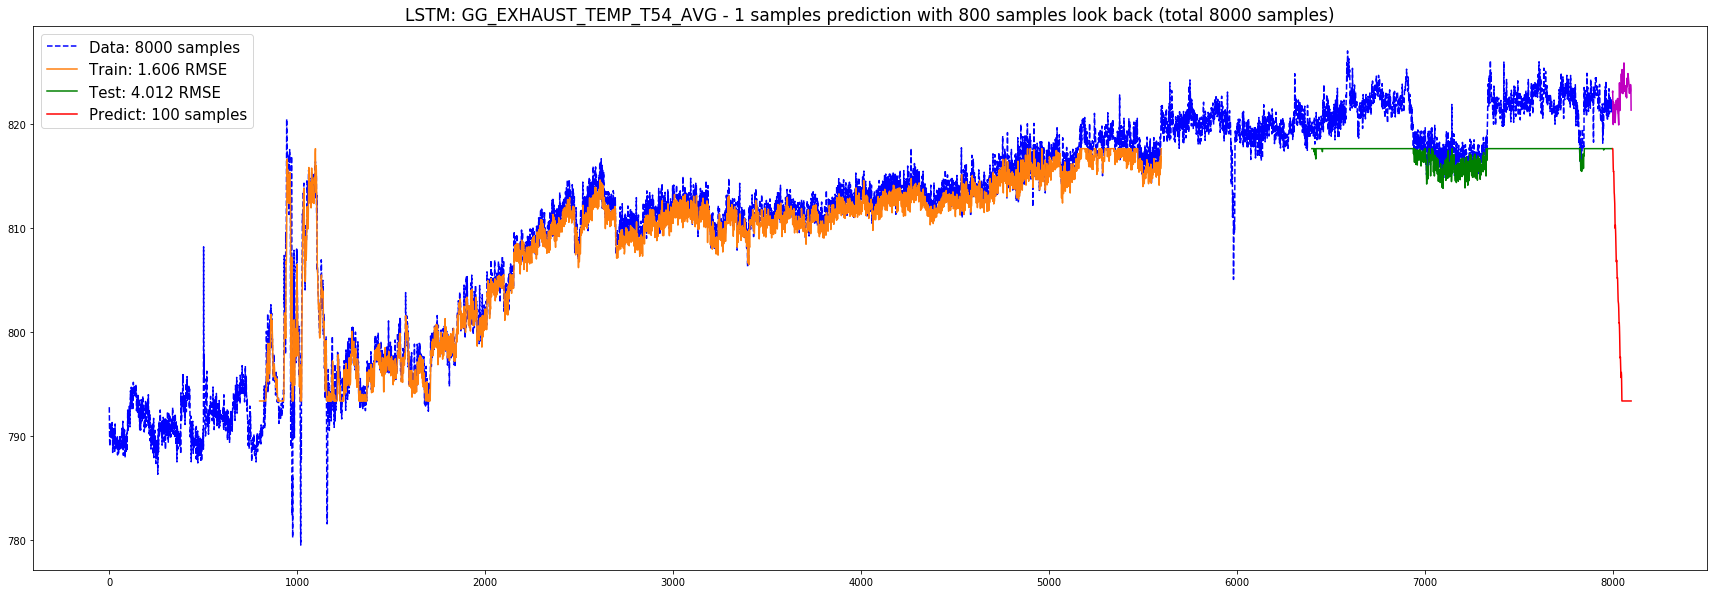

In [10]:
trainPredictPlot = np.zeros(shape=(len(dataset)+len(futurePredict[0]),1))
#trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(unnorm_trainPredict)+look_back,:] = unnorm_trainPredict

testPredictPlot = np.zeros(shape=(len(dataset)+len(futurePredict[0]),1))
testPredictPlot[:,:] = np.nan
testPredictPlot[len(unnorm_trainPredict)+(look_back*2):len(dataset),:] = unnorm_testPredict

futurePredictPlot = np.zeros(shape=(len(dataset)+len(futurePredict[0]),1))
futurePredictPlot[:,:] = np.nan
futurePredictPlot[len(dataset):,:] = np.transpose(futurePredict)

futureTestPlot = np.zeros(shape=(len(dataset)+len(futurePredict[0]),1))
futureTestPlot[:,:] = np.nan
futureTestPlot[len(dataset):,:] = dataset_test

print("MSE: %.4f" %mean_squared_error(np.transpose(futurePredict),dataset_test))
plt.figure(figsize=(30,10))
plt.title('LSTM: %s - %d samples prediction with %d samples look back (total %d samples)' % (feature_name,len(futurePredict),look_back,len(dataset)),fontsize=17)
plt.plot(scaler.inverse_transform(dataset),label="Data: %d samples" %len(dataset),color='b',linestyle='--')
plt.plot(trainPredictPlot,label="Train: %.3f RMSE" %trainScore,color='C1')
plt.plot(testPredictPlot,label="Test: %.3f RMSE" %testScore,color='g')
plt.plot(futurePredictPlot,label="Predict: %d samples" %len(futurePredict[0]),color='r')
plt.plot(futureTestPlot,color='m')
plt.legend(fontsize=15)
plt.savefig('LSTM_prediction.png')
plt.show()